# Comparison of My Emulator to the Intel Quantum Simulator for Speedup and Accuracy

In [1]:
import sys
sys.path.insert(0, '../../ACME/intel-qs/build/lib')
import intelqs_py as simulator
import emulator
import numpy as np
import time
from matplotlib import pyplot as plt

# Add

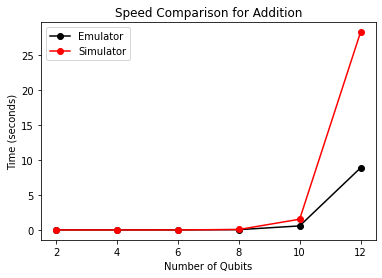

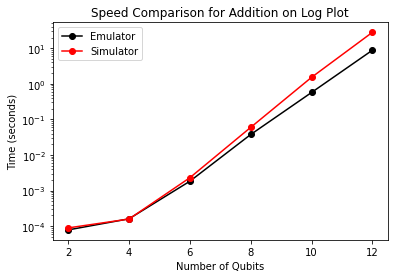

In [2]:
# Define the number of times to repeat the following experiment.
M = 10

# Set the maximum number of qubits to simulate.
N = 12

# Create a list of various numbers of qubits <= N to simulate.
num_qubits = np.arange(2, N+1, 2)

# Define a list to hold the emulator and simulator times respectively.
em_times = []
sim_times = []

# For each iteration of the experiment:
for m in range(M):

    # Define arrays to hold the results of this iteration (batch).
    em_batch = []
    sim_batch = []

    # For each n, we will add two numbers of size n, as follows:
    for n in num_qubits:

        # Initialize the state of the simulator.
        # Note that to add two numbers of size n, we need 2n + 2 qubits.
        psi = simulator.QubitRegister(2*n+2, 'base', 0, 0)
        for i in range(1, 2*n+1):
            psi.ApplyPauliX(i)
        
        # Initialize the state of the emulator.
        # Note that every qubit is set to 1 for both the emulator and simulator.
        a = np.zeros(2**n, dtype=complex)
        a[-1] = 1
        
        # Perform addition with the emulator and time how long it takes.
        start_time = time.time()
        em_state = emulator.add(a, a)
        em_batch.append(time.time() - start_time)

        # Perform the QFT with the simulator and time how long it takes.
        start_time = time.time()
        for i in range(0, 2*n, 2):
            psi.ApplyCPauliX(i+2, i+1)
            psi.ApplyCPauliX(i+2, i)
            psi.ApplyToffoli(i, i+1, i+2)
        psi.ApplyCPauliX(2*n, 2*n+1)
        for i in range(2*n-2, -2, -2):
            psi.ApplyToffoli(i, i+1, i+2)
            psi.ApplyCPauliX(i+2, i)
            psi.ApplyCPauliX(i, i+1)
        sim_batch.append(time.time() - start_time)
        
        # Extract the sum from the simulator state.
        sim_state = []
        for i in range(2**(2*n+2)):
            sim_state.append(psi[i])
        sim_state = np.array(sim_state, dtype=complex)
        sim_indx = bin(sim_state.nonzero()[0][0])
        sim_sum = sim_indx[2::2]

        # Extract the sum from the emulator state.
        em_indx = bin(em_state.nonzero()[0][0])
        em_sum = em_indx[2::1]

        # Ensure that the final states of the emulator and simulator agree.
        if not em_sum == sim_sum:
            print('Output differed for ' + str(n) + ' qubits.')
            print(sim_sum)
            print(em_sum)
            print()

    # Append the batch results to the main array.     
    em_times.append(em_batch)
    sim_times.append(sim_batch)

# Average the times over each batch.
em_times = np.array(em_times)
sim_times = np.array(sim_times)
em_times = np.sum(em_times, axis=0)/M
sim_times = np.sum(sim_times, axis=0)/M

# Plot the times for each addition operation.
plt.plot(num_qubits, em_times, 'o-k', label='Emulator')   
plt.plot(num_qubits, sim_times, 'o-r', label='Simulator')
plt.title('Speed Comparison for Addition')
plt.xlabel('Number of Qubits')
plt.ylabel('Time (seconds)')
plt.legend(loc='best')
plt.savefig('addition.png', dpi=600)
plt.show()

# Plot the times for each addition operation on a log plot.
plt.semilogy(num_qubits, em_times, 'o-k', label='Emulator')   
plt.semilogy(num_qubits, sim_times, 'o-r', label='Simulator')
plt.title('Speed Comparison for Addition on Log Plot')
plt.xlabel('Number of Qubits')
plt.ylabel('Time (seconds)')
plt.legend(loc='best')
plt.savefig('addition_log.png', dpi=600)
plt.show()

# QFT

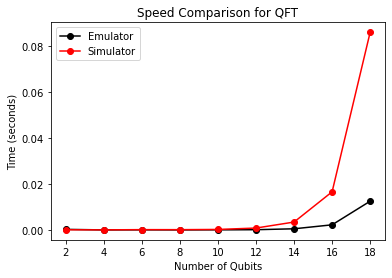

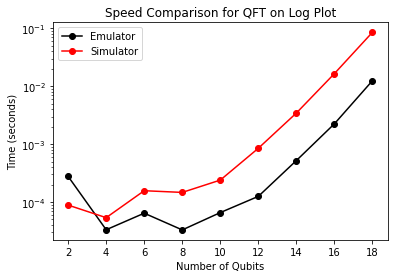

In [3]:
# Define the number of times to repeat the following experiment.
M = 10

# Set the maximum number of qubits to simulate.
N = 18

# Define the z-rotations needed for the simulation method.
Z = []
for n in range(2, N+1):
   Z.append(np.array([[1, 0], [0, np.exp(1j*2*np.pi/2**n)]], dtype=complex)) 

# Create a list of various numbers of qubits <= N to simulate.
num_qubits = np.arange(2, N+1, 2)

# Define a list to hold the emulator and simulator times respectively.
em_times = []
sim_times = []

# For each iteration of the experiment:
for m in range(M):

    # Define arrays to hold the results of this iteration (batch).
    em_batch = []
    sim_batch = []
        
    # For each number of qubits:
    for n in num_qubits:
        
        # Initialize the simulator to a random state.
        psi = simulator.QubitRegister(n, 'base', 0, 0)
        rng = simulator.RandomNumberGenerator()
        seed = np.random.randint(0, 10000, 1)
        rng.SetSeedStreamPtrs(seed)
        psi.SetRngPtr(rng)
        psi.Initialize('rand', 0)
        
        # Extract the simulator state to pass it into the emulator.
        state = []
        for i in range(2**n):
            state.append(psi[i])
        state = np.array(state, dtype=complex)
        
        # Perform the QFT with the emulator and time how long it takes.
        start_time = time.time()
        em_state = emulator.qft(state)
        em_batch.append(time.time() - start_time)

        # Perform the QFT with the simulator and time how long it takes.
        start_time = time.time()
        for i in range(n-1, -1, -1):
            psi.ApplyHadamard(i)
            for j in range(0, i, 1):
                psi.ApplyControlled1QubitGate(j, i, Z[i-j-1])
        for i in range(n//2):
            psi.ApplySwap(i, n-i-1)
        sim_batch.append(time.time() - start_time)
        
        # Extract the resultant state from the simulator.
        sim_state = []
        for i in range(2**n):
            sim_state.append(psi[i])
        sim_state = np.array(sim_state, dtype=complex)
        
        # Ensure that the final states of the emulator and simulator agree.
        if not np.allclose(sim_state, em_state):
            print('Output differed for ' + str(n) + ' qubits.')
            print(sim_state)
            print(em_state)
            print()

    # Append the batch results to the main array.     
    em_times.append(em_batch)
    sim_times.append(sim_batch)
        
# Average the times over each batch.
em_times = np.array(em_times)
sim_times = np.array(sim_times)
em_times = np.sum(em_times, axis=0)/M
sim_times = np.sum(sim_times, axis=0)/M

# Plot the times for each QFT operation.
plt.plot(num_qubits, em_times, 'o-k', label='Emulator')   
plt.plot(num_qubits, sim_times, 'o-r', label='Simulator')
plt.title('Speed Comparison for QFT')
plt.xlabel('Number of Qubits')
plt.ylabel('Time (seconds)')
plt.legend(loc='best')
plt.savefig('qft.png', dpi=600)
plt.show()

# Plot the times for each QFT operation on a log plot.
plt.semilogy(num_qubits, em_times, 'o-k', label='Emulator')   
plt.semilogy(num_qubits, sim_times, 'o-r', label='Simulator')
plt.title('Speed Comparison for QFT on Log Plot')
plt.xlabel('Number of Qubits')
plt.ylabel('Time (seconds)')
plt.legend(loc='best')
plt.savefig('qft_log.png', dpi=600)
plt.show()

# QPE

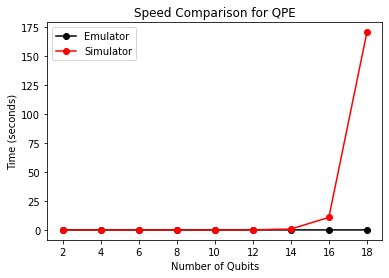

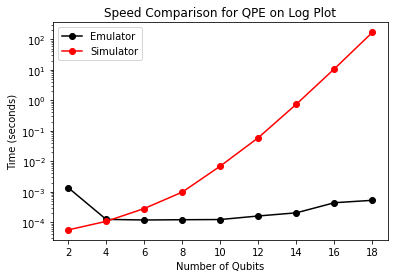

In [4]:
# Define the number of times to repeat the following experiment.
M = 10

# Set the maximum number of qubits to simulate.
N = 18

# Define the z-rotations needed for the simulation method.
Z = []
for n in range(1, N):
   Z.append(np.array([[1, 0], [0, np.exp(-1j*np.pi/2**n)]], dtype=complex))

# Create a list of various numbers of qubits <= N to simulate.
num_qubits = np.arange(2, N+1, 2)

# Define a list to hold the emulator and simulator times respectively.
em_times = []
sim_times = []

# For each iteration of the experiment:
for m in range(M):

    # Define arrays to hold the results of this iteration (batch).
    em_batch = []
    sim_batch = []

    # For each number of qubits:
    for n in num_qubits:

        # Define a matrix (U) and an eigenvector.
        z = np.random.uniform(0, 1)
        U = np.array([[1, 0], [0, np.exp(1j*z)]])
        phi = np.array([0, 1])
        
        # Initialize the simulator to the 0 state.
        psi = simulator.QubitRegister(n+1, 'base', 0, 0)
        
        # Extract the simulator state to pass it into the emulator.
        state = []
        for i in range(2**n):
            state.append(psi[i])
        state = np.array(state, dtype=complex)
        
        # Perform the QPE with the emulator and time how long it takes.
        start_time = time.time()
        em_state = emulator.qpe(U, phi, n)
        em_batch.append(time.time() - start_time)

        # Perform the QPE with the simulator and time how long it takes.
        start_time = time.time()
        for i in range(n):      # Initialize.
            psi.ApplyHadamard(i)
        psi.ApplyPauliX(n)
        for i in range(0, n):   # Modular exponentiation.
            for j in range(2**i):
                psi.ApplyControlled1QubitGate(i, n, U)
        for i in range(n//2):   # Inverse QFT.
            psi.ApplySwap(i, n-i-1)
        for j in range(n):
            for m in range(j):
                psi.ApplyControlled1QubitGate(m, j, Z[j-m-1])
            psi.ApplyHadamard(j)
        for i in range(n):      # Measure (and normalize).
            prob = psi.GetProbability(i)
            if prob < 0.5:
                psi.CollapseQubit(i, False)
            else:
                psi.CollapseQubit(i, True)
            psi.Normalize()
        sim_batch.append(time.time() - start_time)
        
        # Extract the resultant state from the simulator.
        sim_state = []
        for i in range(2**n, 2**(n+1)):
            sim_state.append(psi[i])
        sim_state = np.array(sim_state, dtype=complex)
        
        # Ensure that the final states of the emulator and simulator agree.
        # Note that the nonzero entry of the statevector is complex with norm 1,
        # so we take the absolute value to match its form to the emulator.
        if not np.allclose(np.abs(sim_state), em_state):
            print('Output differed for ' + str(n) + ' qubits.')
            print(sim_state)
            print(em_state)
            print()
        
    # Append the batch results to the main array.     
    em_times.append(em_batch)
    sim_times.append(sim_batch)

# Average the times over each batch.
em_times = np.array(em_times)
sim_times = np.array(sim_times)
em_times = np.sum(em_times, axis=0)/M
sim_times = np.sum(sim_times, axis=0)/M

# Plot the times for each QPE operation.
plt.plot(num_qubits, em_times, 'o-k', label='Emulator')   
plt.plot(num_qubits, sim_times, 'o-r', label='Simulator')
plt.title('Speed Comparison for QPE')
plt.xlabel('Number of Qubits')
plt.ylabel('Time (seconds)')
plt.legend(loc='best')
plt.savefig('qpe.png', dpi=600)
plt.show()

# Plot the times for each QPE operation on a log plot.
plt.semilogy(num_qubits, em_times, 'o-k', label='Emulator')   
plt.semilogy(num_qubits, sim_times, 'o-r', label='Simulator')
plt.title('Speed Comparison for QPE on Log Plot')
plt.xlabel('Number of Qubits')
plt.ylabel('Time (seconds)')
plt.legend(loc='best')
plt.savefig('qpe_log.png', dpi=600)
plt.show()